## Clase 7: Evaluación de Clasificadores

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
import patsy

loan = pd.read_csv('loan.csv')

split = train_test_split(loan.index, test_size = 0.3)
train = loan.loc[split[0]]
test = loan.loc[split[1]]

ytr, Xtr = patsy.dmatrices("""SeriousDlqin2yrs ~ RevolvingUtilizationOfUnsecuredLines + DebtRatio +
                   np.log(MonthlyIncome + 1)""",
                  data = train)
yte, Xte = patsy.dmatrices("""SeriousDlqin2yrs ~ RevolvingUtilizationOfUnsecuredLines + DebtRatio +
                   np.log(MonthlyIncome + 1)""",
                   data = test)


Ajuste de regresión logística sencilla.

In [2]:
fit_1 = sm.Logit(ytr, Xtr)
fit_1 = fit_1.fit()
preds = fit_1.predict(Xte)

Optimization terminated successfully.
         Current function value: 0.252926
         Iterations 7


Cálculo y gráfico de las ROC

In [3]:
roc = metrics.roc_curve(yte, preds)
metrics.auc(roc[0], roc[1])

0.573610311972851

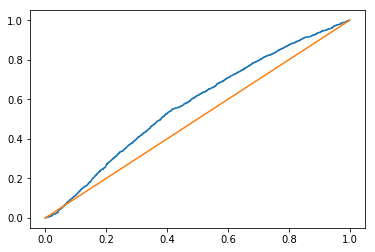

In [4]:
import matplotlib.pyplot as plt
plt.plot(roc[0], roc[1])
plt.plot([0,1], [0,1])
plt.show()

La curva de ROC es muy pobre (pues no se trataron los datos bien antes!) sin embargo no hay que dejarse engañar por esto, pues notemos que:

In [5]:
ytr.sum()/len(ytr)

array(0.06982627)

Notar el desbalance en el train!! 
En lugar de usar el AUC y la ROC como indicador, se sugiere utilizar la curva PR y el AUC de la misma como indicador.

In [6]:
pres, rec, _ = metrics.precision_recall_curve(yte, preds)
auc = metrics.average_precision_score(yte, preds)

In [7]:
auc

0.08060300905409702

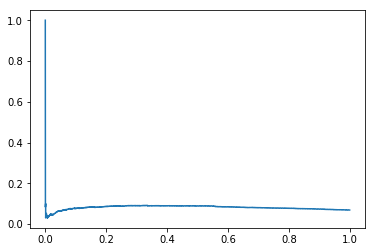

In [8]:
plt.plot(rec, pres)
plt.show()

En general independiente del punto de corte que se elija, la precición es bajísisma!, esto pues al ser tantos ceros, se nos disparará la tasa de falsos positivos, en efecto aunque nuestro modelo ordene muy bien los unos, 13 veces más ceros que unos! El modo correcto de operar es balanceando la muestra antes de entrenar. 

### Modelos aditivos generalizados

In [9]:
ytr, Xtr = patsy.dmatrices("""SeriousDlqin2yrs ~ RevolvingUtilizationOfUnsecuredLines + DebtRatio + np.log(MonthlyIncome + 1)""", data = train)

Ajustamos un modelo a modo de comparación.

In [10]:
from sklearn import linear_model as lm
logistica = lm.LogisticRegression().fit(Xtr, np.ravel(ytr)).predict_proba(Xte)

C:\Users\simon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
roc_log = metrics.roc_curve(yte, logistica[:, 1])
print(metrics.auc(roc_log[0], roc_log[1]))

0.5736057919321144


Para ajustar gam una librería es la pygam.

In [12]:
#pip install pygam
from pygam import LogisticGAM

en pyGAM hay varias opciones para la naturaleza de la variables respuesta, algunas de ellas:

- LinearGAM -> para ajustes de respuesta normal
- LogisticGAM -> para clasificación
- GammaGAM -> regresión de respuesta positiva
- PoissonGAM -> regresión de conteo
- InvGaussGAM -> variable respuesta muy asimétrica

Partamos con el ajuste más simple posible

In [13]:
gam = LogisticGAM().fit(Xtr, ytr)

Un resumen rápido se puede ver con el summary, el cual entrega un resultado tipo R

In [14]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     15.4874
Link Function:                        LogitLink Log Likelihood:                                -21042.9604
Number of Samples:                        84209 AIC:                                            42116.8957
                                                AICc:                                           42116.9026
                                                UBRE:                                               2.5003
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.013
Feature Function                  Lam

C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [15]:
preds = gam.predict_proba(Xte)
roc_gam = metrics.roc_curve(yte, preds)
print(metrics.auc(roc_gam[0], roc_gam[1]))

0.5872791315453391


El modelo como está es apenas mejor que una logística, revisemos con más detalle su ajuste.

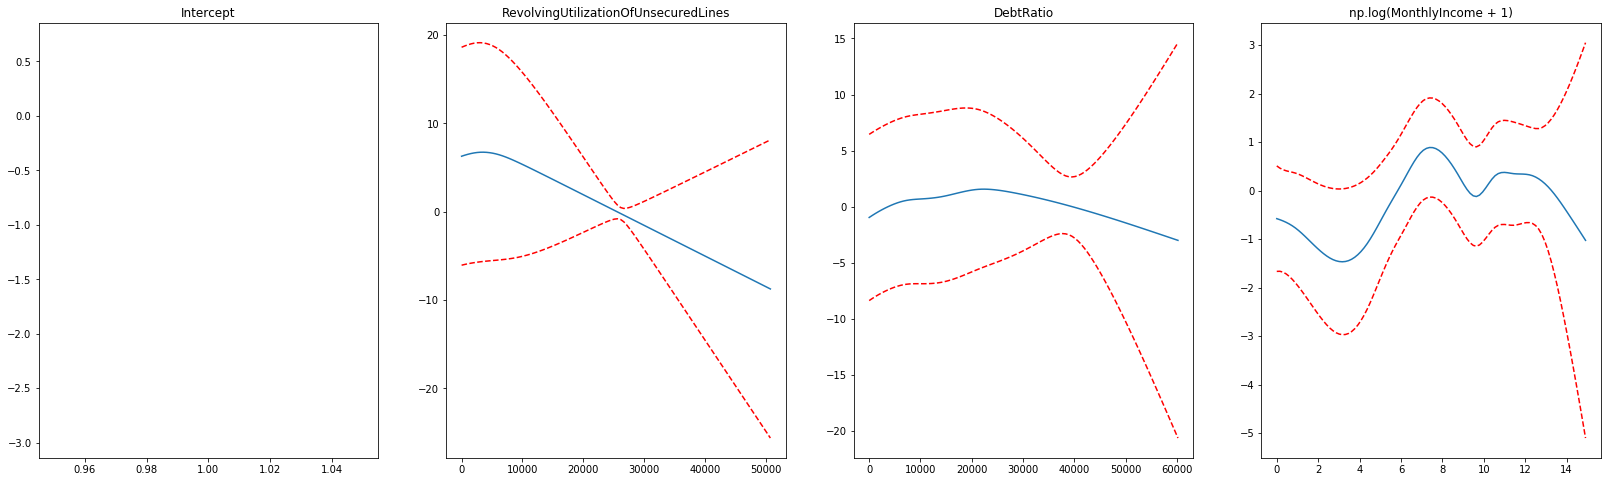

In [16]:
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, 4)
titles = ['Intercept',
    'RevolvingUtilizationOfUnsecuredLines',
     'DebtRatio',
     'np.log(MonthlyIncome + 1)']
for i, ax in enumerate(axs):
    XX  = gam.generate_X_grid(term = i)
    ax.plot(XX[:, i], gam.partial_dependence(term = i, X = XX))
    ax.plot(XX[:, i], gam.partial_dependence(term = i, X = XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])


Las variables más relevantes al ajustar un GAM son el número de splines y el parámetro de regularización. Estos son por default 25 y 0.6 respectivamente. Ajustemos denuevo con algunos cambios

In [17]:
lambda_ = 0.2
n_splines = [4, 30, 20, 30] 
gam = LogisticGAM(lam = lambda_,
         n_splines = n_splines).fit(Xtr, ytr)

In [18]:
preds = gam.predict_proba(Xte)
roc_gam = metrics.roc_curve(yte, preds)
print(metrics.auc(roc_gam[0], roc_gam[1]))

0.5880644766019429


In [19]:
pres, rec, _ = metrics.precision_recall_curve(yte, preds)
auc = metrics.average_precision_score(yte, preds)

In [20]:
auc

0.08908072595767039

Un GAM se puede generalizar usando la función GAM

```gam = GAM(distribution='gamma', link='inverse')```

En distribution soporta:

- Normal
- Binomial
- Gamma
- Poisson
- Inverse Gaussian

Y en link

- Identity
- Logit
- Inverse
- Log
- Inverse-squared

Las cuales son las más comunes.